In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from getdist import plots, MCSamples, loadMCSamples
import classy as Class
import getdist
import pickle as pkl

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True

dirname = "/Users/gabe/projects/emulators/data/modrec/chains"
sample_path = os.path.join(dirname, "modrec")
s = loadMCSamples(sample_path, settings={'ignore_rows': 0.5})

In [2]:
def find_index_of(array, values):
    indices_return = []
    for value in values:
        test = np.where(array<value, 1, 0)
        ind = np.argwhere(np.diff(test)!=0)[0][0]
        indices_return.append(ind)
    return indices_return

######################################################
# Loading best fit values for LCDM run and computing
######################################################

dirname = "/Users/gabe/projects/cobaya/data/lcdm_baseline_fixed_connect/chains"
sample_path = os.path.join(dirname, "lcdm_baseline_fixed_connect")
ll_max = 4000 #maximum \ell we will consider
lcdm_sample = loadMCSamples(sample_path, settings={'ignore_rows': 0.25})
lcdm_bestfit = lcdm_sample.getParamBestFitDict()
common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'none',
                   'N_ur': 2.0308,
                   'N_ncdm': 1,
                   'm_ncdm': 0.06,
                   'T_ncdm': 0.71611, #1 species of massive neutrinos
                   'l_max_scalars': ll_max,
                   'start_sources_at_tau_c_over_tau_h': 0.004
                  }

precision_settings = {'accurate_lensing': 1,
                            'k_max_tau0_over_l_max': 15,
                            'perturbations_sampling_stepsize': 0.05,
                            'start_sources_at_tau_c_over_tau_h': 0.004}

param_dict = {'H0': lcdm_bestfit["H0"],
              'omega_b': lcdm_bestfit["omega_b"],
              'omega_cdm': lcdm_bestfit["omega_cdm"],
              'ln10^{10}A_s': lcdm_bestfit["logA"],
              'n_s': lcdm_bestfit["n_s"],
              'tau_reio': lcdm_bestfit["tau_reio"]
              }

common_settings.update(param_dict)
common_settings.update(precision_settings)

M = Class.Class()
M.set(common_settings)
M.compute()

######################################################
# Computing fiducial thermodynamics
######################################################

thermo = M.get_thermodynamics()

cutoff_redshifts = [200, 2500]

cutoffs = find_index_of(thermo["z"], cutoff_redshifts)
z = thermo['z']
xe_fid = thermo['x_e']
g_fid = thermo["kappa' [Mpc^-1]"]*thermo["exp(-kappa)"]


Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin, because
ll = np.arange(2, ll_max+1)
muK2 = (Tcmb)**2

######################################################
# Computing fiducial spectra
######################################################

tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:] # 2:, because we want to ignore the monopole and dipole
te_fid = muK2*M.lensed_cl(ll_max)['te'][2:]
ee_fid = muK2*M.lensed_cl(ll_max)['ee'][2:]


In [10]:
modrec = s.getParams().__dict__
H0_high_bounds = [72, 73]
high_H0_ind = np.argwhere(np.logical_and((modrec["chi2__CMB"]-lcdm_bestfit["chi2__CMB"])<0, np.logical_and(modrec["H0"]>H0_high_bounds[0], modrec["H0"]<H0_high_bounds[1]))).flatten()

H0_low_bounds = [66.813, 67.813]
low_H0_ind = np.argwhere(np.logical_and((modrec["chi2__CMB"]-lcdm_bestfit["chi2__CMB"])<0, np.logical_and(modrec["H0"]>H0_low_bounds[0], modrec["H0"]<H0_low_bounds[1]))).flatten()
low_H0_ind = low_H0_ind[::150]

print(lcdm_bestfit["chi2__CMB"])
print(len(high_H0_ind))

1003.809977
64


In [22]:
band_left_edges = np.arange(67.5, 73, 0.5)
select_H0_ind = []
for le in band_left_edges:
    bounds=[le, le+0.5]
    select_H0_ind.append(np.random.choice(np.argwhere(np.logical_and((modrec["chi2__CMB"]-lcdm_bestfit["chi2__CMB"])<0, np.logical_and(modrec["H0"]>bounds[0], modrec["H0"]<bounds[1]))).flatten()))
print(select_H0_ind)

[2664856, 2840894, 2345952, 631497, 2172441, 2014998, 2703977, 868887, 2303275, 2746783, 1201606]


In [36]:
common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'control',
                   'xe_pert_num': 7,
                   'zmin_pert': 800,
                   'zmax_pert': 1400,
                   'xe_control_pivots': "800.0000,900.0000,1000.0000,1100.0000,1200.0000,1300.0000,1400.0000",
                   'N_ur': 2.0308,
                   'N_ncdm': 1,
                   'm_ncdm': 0.06,
                   'T_ncdm': 0.71611, #1 species of massive neutrinos
                   'l_max_scalars': ll_max,
                   'start_sources_at_tau_c_over_tau_h': 0.004
                  }

M = Class.Class()
M.set(common_settings)

tt_high_dict = {}
te_high_dict = {}
ee_high_dict = {}

xe_dict = {}
xe_fid_dict = {}
xe_pert_dict = {}
g_dict = {}

for i in select_H0_ind:
    cp_string = "0.0,{},{},{},{},{},0.0".format(modrec["q_1"][i], modrec["q_2"][i], modrec["q_3"][i], modrec["q_4"][i], modrec["q_5"][i])
    param_dict = {'H0': modrec["H0"][i],
                'omega_b': modrec["omega_b"][i],
                'omega_cdm': modrec["omega_cdm"][i],
                'ln10^{10}A_s': modrec["logA"][i],
                'n_s': modrec["n_s"][i],
                'tau_reio': modrec["tau_reio"][i],
                "xe_control_points": cp_string
                }
    M.set(param_dict)
    M.compute(level=["thermodynamics"])
    print(modrec["H0"][i])
    Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin, because
    muK2 = (Tcmb)**2
    thermo = M.get_thermodynamics()
    xe_dict[i] = thermo["x_e"]
    xe_fid_dict[i] = thermo["x_fid"]
    xe_pert_dict[i] = thermo["xe_pert"]
    gz = thermo["kappa' [Mpc^-1]"]*thermo["exp(-kappa)"]
    g_dict[i] = gz
    #tt = muK2*M.lensed_cl(ll_max)['tt'][2:] # 2:, because we want to ignore the monopole and dipole
    #te = muK2*M.lensed_cl(ll_max)['te'][2:]
    #ee = muK2*M.lensed_cl(ll_max)['ee'][2:]
    #tt_high_dict[i] = tt
    #te_high_dict[i] = te
    #ee_high_dict[i] = ee


67.759321
68.008747
68.55017
69.054946
69.725222
70.410246
70.784254
71.342807
71.66552
72.194511
72.521898


/var/folders/dx/56r119096g71nr7d270292b80000gn/T/ipykernel_25205/930666643.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap, label="$H_0$")


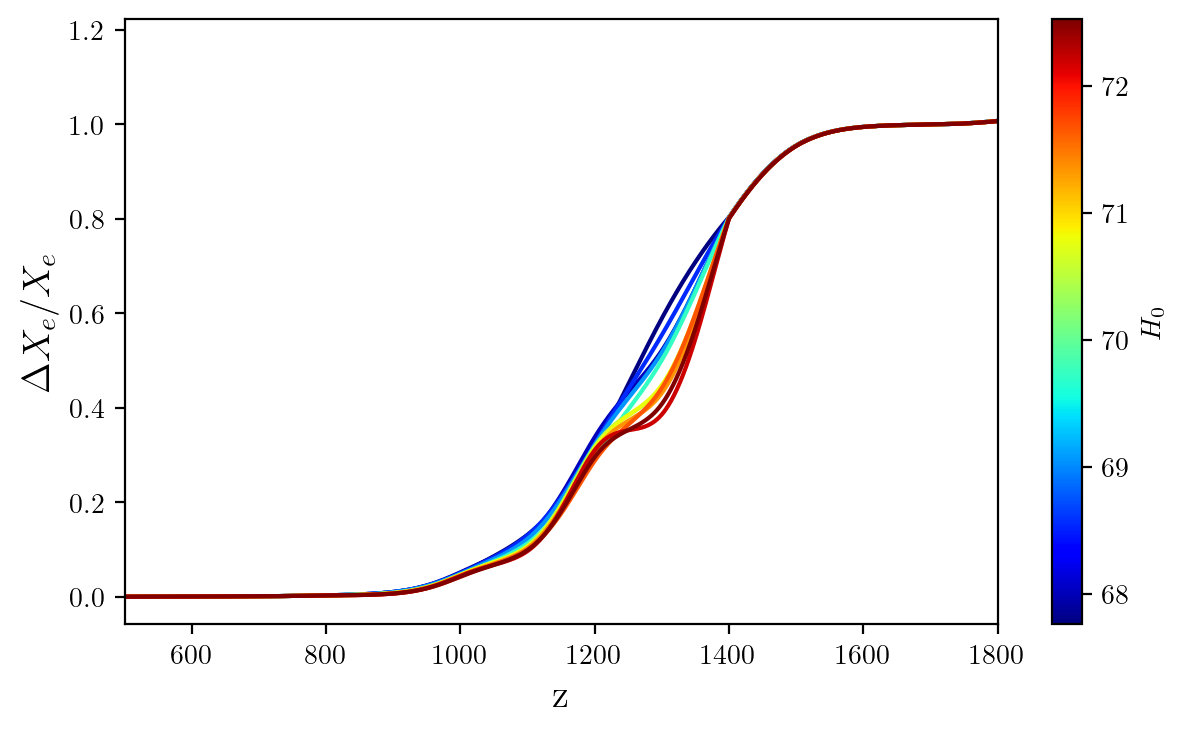

In [43]:
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 10,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

fig,ax = plt.subplots()
fig.set_size_inches(w=7.04, h=3.93)

norm = mpl.colors.Normalize(vmin=np.min(modrec["H0"][select_H0_ind]), vmax=np.max(modrec["H0"][select_H0_ind]))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
#cmap = plt.get_cmap('RdBu', np.max(data) - np.min(data) + 1)
cmap.set_array([])

for ind, func in xe_dict.items():
    ax.plot(z, func, color = cmap.to_rgba(modrec["H0"][ind]))

#ax.plot(z, g_fid, color="black", alpha=0.7)
ax.set_xlim(500, 1800)
ax.set_ylabel("$\Delta X_e / X_e$", fontsize=14)
ax.set_xlabel("z", fontsize=14)
fig.colorbar(cmap, label="$H_0$")
#plt.savefig("../results/delta_xe_frac_H0_selections.png",dpi=300, bbox_inches='tight')
plt.show()

In [9]:
high_H0_color = "cornflowerblue"
low_H0_color = "firebrick"

## Fine grain bands

[   2    3    4 ... 3998 3999 4000]


/var/folders/dx/56r119096g71nr7d270292b80000gn/T/ipykernel_28991/2110859224.py:64: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap)


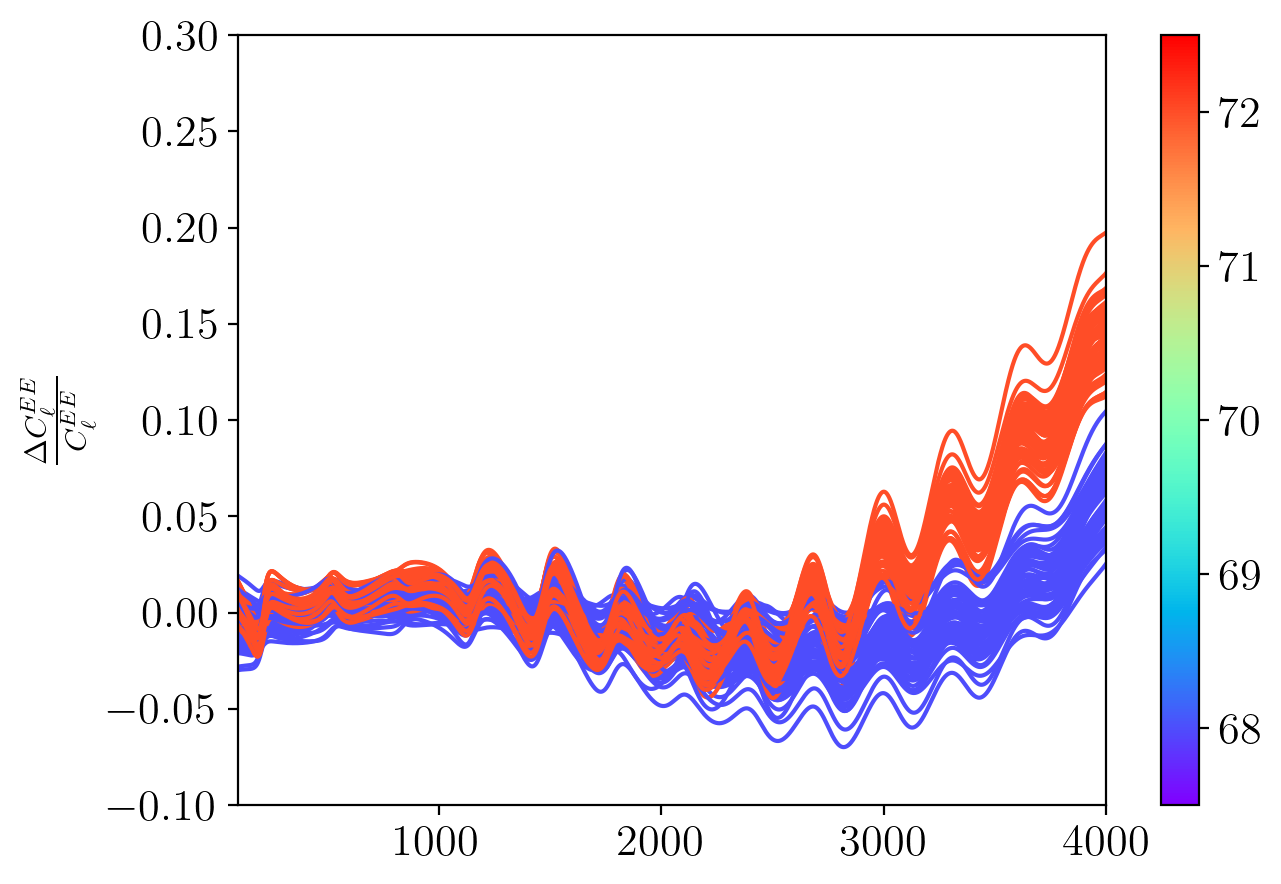

In [24]:
labels = {"tt": "$\\frac{\Delta C_\ell^{TT}}{C_\ell^{TT}}$",
          "te": "$\\frac{\Delta C_\ell^{TE}}{\sqrt{(C_\ell^{TE})^2 + C_\ell^{EE} C_\ell^{TT}} }$",
          "ee": "$\\frac{\Delta C_\ell^{EE}}{C_\ell^{EE}}$"}

spectra = ["tt", "te", "ee"]

xx_fid = {"tt": tt_fid,
          "te":te_fid,
          "ee": ee_fid}

band_left_edges = np.arange(67.5, 73, 0.5)

norm = mpl.colors.Normalize(vmin=band_left_edges[0], vmax=band_left_edges[-1])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.rainbow)
cmap.set_array([])

color_dict = {}
for edge in band_left_edges:
    color_dict[edge] = cmap.to_rgba(edge)

Tcmb = 2725500.0
muK2 = (Tcmb)**2

def plot_bands(ax, xx, bands_to_plot=band_left_edges):

    xx_hp = np.load("../data/precision_spectra/{}_hp.npy".format(xx))
    indices = [int(i) for i in xx_hp[:,0]]

    ll = np.arange(2, 4001)
    print(ll)

    for row in xx_hp:
        i = int(row[0])
        cl = muK2*row[1:]
        H = modrec["H0"][i]
        color_band = 0

        ref = xx_fid[xx]
        #ref = 1
        if xx=="te":
            ref = np.sqrt(te_fid**2 + ee_fid*tt_fid)

        for edge in band_left_edges:
            if edge <= H < edge+.5:
                color_band = edge
        if color_band in bands_to_plot:
            ax.plot(ll, (cl-xx_fid[xx])/(ref), color=color_dict[color_band])
        else:
            continue

        ax.set_ylim([-0.1,0.3])
        ax.set_xlim([100, 4000])
        ax.set_ylabel(labels[xx])

    return ax

fig,ax = plt.subplots(figsize=(7,5))  

ax = plot_bands(ax, "ee", bands_to_plot=[68, 72])
#ax.plot(ll, ())
#ax.set_ylim([-2e-7, 3e-7])
#ax.set_xlim([2000, 4000])
#ax.set_ylabel("$\Delta C_\ell^{EE}$")
fig.colorbar(cmap)

plt.show()


In [87]:
te_hp = np.load("../src/{}_hp.npy".format("te"))
print(te_hp)

[[ 3.49489000e+05  3.63433526e-13  2.03446656e-13 ... -8.49762800e-21
  -8.46354970e-21 -8.42952622e-21]
 [ 5.78612000e+05  3.73148464e-13  2.11146340e-13 ... -7.98940616e-21
  -7.95703351e-21 -7.92472159e-21]
 [ 1.25612000e+06  3.46499718e-13  1.91142828e-13 ... -8.47333865e-21
  -8.43831624e-21 -8.40337984e-21]
 ...
 [ 2.80123600e+06  3.82667358e-13  2.21849366e-13 ... -9.95755751e-21
  -9.91695378e-21 -9.87642992e-21]
 [ 3.87380800e+06  3.82961433e-13  2.15143956e-13 ... -9.81131248e-21
  -9.77178924e-21 -9.73233570e-21]
 [ 2.08390000e+06  3.58215829e-13  1.99744168e-13 ... -1.04712379e-20
  -1.04278038e-20 -1.03844747e-20]]
